# **===============> Capstone Project <=================**

## Problem Statement
CT Scan Images Classification

#### Data Overview
This dataset contains 1252 Ct scans that are positive for SARS-CoV-2 infection (COVID-19) and 1230 CT scans for patients no-infected by SARS-CoV-2 scans in total. These data have been collected from real parients in hospitals from Sao Paulo, Brazil. The aim of this dataset is to encourage the resarch and development of artificial intelligence methods which are able to identify if a person is infected by SARS-CoV-2 through the analysis of his/her CT scans. 

### ✈ **Steps To Complete This Capstone Project**
  1- Download the Data from this Link.
        https://drive.google.com/drive/folders/1WOeodRmv1Mw5Cswuip3nUIi6ViQWKpo_?usp=sharing

  2- the images are in differnet sizes so you have to take a fixed size on which you have to work.

  3- Do data augmentation on it, mention at least 5args inside it.

  4- Train Model on it you only have to use resnet from resnet you can pick any layer model like - ResNet-18, ResNet-34, ResNet-50, ResNet-101, ResNet-110, ResNet-152, ResNet-164, ResNet-1202.
  
  And mention early stopping and modelcheckpoint while training.

  5- Do Prediction and mention multiple performance metrics.


# 1. **Import** the Rquired **Libraries**

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
import cv2
import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import plot_model

# Supress info, warnings and error messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print("All Libraries are Imported Succesfully")

All Libraries are Imported Succesfully


# 2. **Load** the **Dataset**

In [2]:
disease_types = ['Covid', 'Non-Covid']

train_dir = data_dir = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/Dataset'
train_data = []

for index, sp in enumerate(disease_types):
  for file in os.listdir(os.path.join(train_dir, sp)):
    train_data.append([sp + "/" + file, index, sp])

train = pd.DataFrame(train_data, columns = ['File', 'ID', 'Disease Type'])
train

,File,ID,Disease Type
0,Covid/Covid (726).png,0,Covid
1,Covid/Covid (810).png,0,Covid
2,Covid/Covid (727).png,0,Covid
3,Covid/Covid (757).png,0,Covid
4,Covid/Covid (742).png,0,Covid
...,...,...,...
2476,Non-Covid/Non-Covid (671).png,1,Non-Covid
2477,Non-Covid/Non-Covid (733).png,1,Non-Covid
2478,Non-Covid/Non-Covid (727).png,1,Non-Covid
2479,Non-Covid/Non-Covid (695).png,1,Non-Covid


## Setting Up the Dataset and adding column for the Histogram

,File,ID,Disease Type
0,Covid/Covid (727).png,0,Covid
1,Covid/Covid (277).png,0,Covid
2,Covid/Covid (29).png,0,Covid
3,Non-Covid/Non-Covid (540).png,1,Non-Covid
4,Covid/Covid (1203).png,0,Covid
...,...,...,...
2476,Non-Covid/Non-Covid (254).png,1,Non-Covid
2477,Non-Covid/Non-Covid (802).png,1,Non-Covid
2478,Non-Covid/Non-Covid (1052).png,1,Non-Covid
2479,Non-Covid/Non-Covid (1034).png,1,Non-Covid


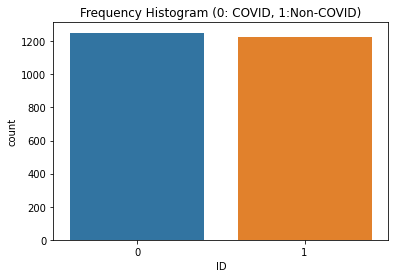

In [3]:
Seed = 40

train = train.sample(frac = 1, replace=False, random_state = Seed)

# Reset indices (row numbers)
train = train.reset_index(drop = True)

sns.countplot(x = "ID", data = train).set_title("Frequency Histogram (0: COVID, 1:Non-COVID)")
train

##### Observation :    
1. We have total 2481 Images in our dataset.
2. Positive are 1250 CT scan images.
3. Negatice are 1230 CT scan images.

## Ploting the Images

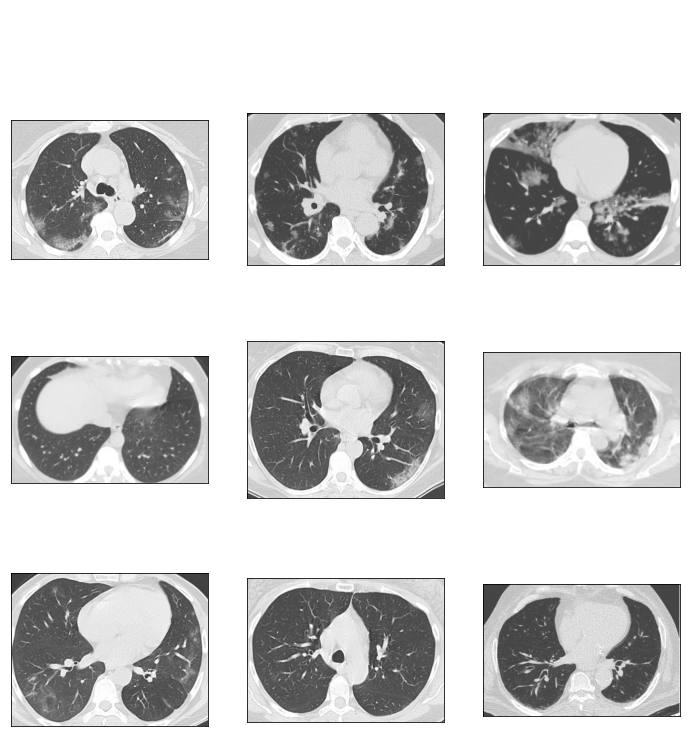

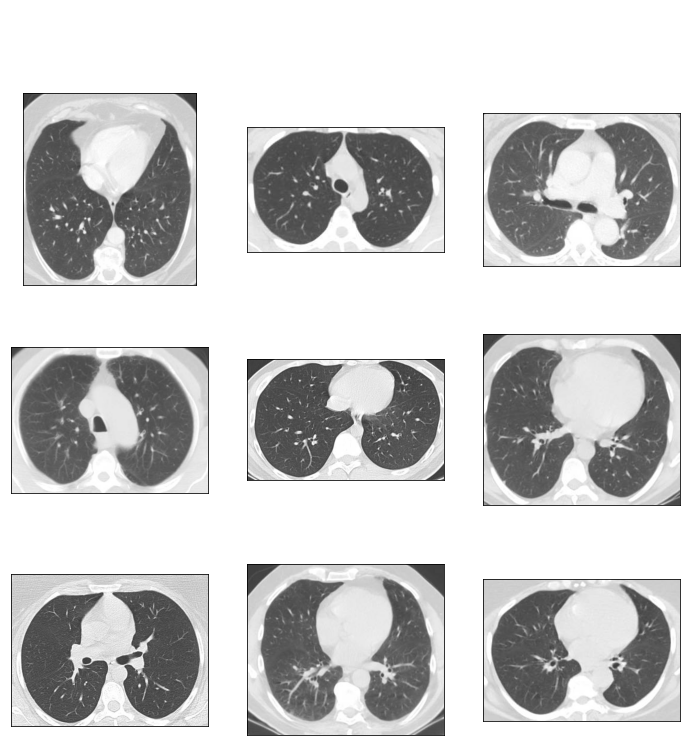

In [4]:
from collections.abc import ValuesView
def plot_defects(defect_types, rows, cols):
  fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
  defect_files = train['File'][train['Disease Type'] == defect_types].values
  n = 0
  fig.suptitle(defect_types, fontsize = 22, color = "white")
  for i in range(rows):
    for j in range(cols):
      image_path = os.path.join(data_dir, defect_files[n])
      ax[i, j].set_xticks([])
      ax[i, j].set_yticks([])
      ax[i, j].imshow(cv2.imread(image_path))
      n = n+1

plot_defects('Covid', 3, 3)
plot_defects('Non-Covid', 3, 3)

# 3. **Resizing** the **Images**

In [5]:
IMAGE_SIZE = 224

# OpenCV Function to load colored image
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

# OpenCV Function to resize an image
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

##### Observations :     
Here I am resizing all the images to one size so that my model can train perfectly and do right predictions.

In [6]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in enumerate(train['File'].values):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

X_Train = X_train / 255.0   # Pixel normalization
print('Train Shape:', X_Train.shape)

Y_train = to_categorical(train['ID'].values, num_classes = 2)

print(Y_train)

Train Shape: (2481, 224, 224, 3)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


# 4. **Spliting** the **Dataset** into **Train and Test**

In [7]:
# Dataframe split to train and validation set (80% train and 20% validation)
X_train, X_val, Y_train, Y_val = train_test_split(X_Train,
                                                  Y_train,
                                                  test_size = 0.2, # Percent 20% of the data is using as test set
                                                  random_state = Seed)

print(f'X_train:', X_train.shape)
print(f'X_val:', X_val.shape)
print(f'Y_train:', Y_train.shape)
print(f'Y_val:', Y_val.shape)

X_train: (1984, 224, 224, 3)
X_val: (497, 224, 224, 3)
Y_train: (1984, 2)
Y_val: (497, 2)


# 5. **Building Model ResNet50**

In [8]:
# Architectural function for DenseNet-169
def build_ResNet50(IMAGE_SIZE, channels):

    resnet50 = ResNet50(weights = 'imagenet', include_top = False)

    input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, channels))
    x = Conv2D(3, (3, 3), padding = 'same')(input)
    x = resnet50(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation = 'relu')(x)
    x = BatchNormalization()(x)
    
    output = Dense(2, activation = 'softmax')(x)
 
    # model
    model = Model(input, output)
    
    optimizer = Adam(learning_rate = 0.003, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0)
    model.compile(loss = 'categorical_crossentropy',  # minimize the negative multinomial log-likelihood also known as the cross-entropy.
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    model.summary()
    
    return model

##### Observations :      
  1- Here I am training my model from ResNet50.

  2- I am using Imagenet for wights.

  3- For my model input size is 224.

  4- Conv2d layer, Global Average Pooling, Batch Normalization these parameters i am using here.

  5- My loss will be the Categorical Crossentropy 


## **Data Augmentation**

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       84        
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                131136

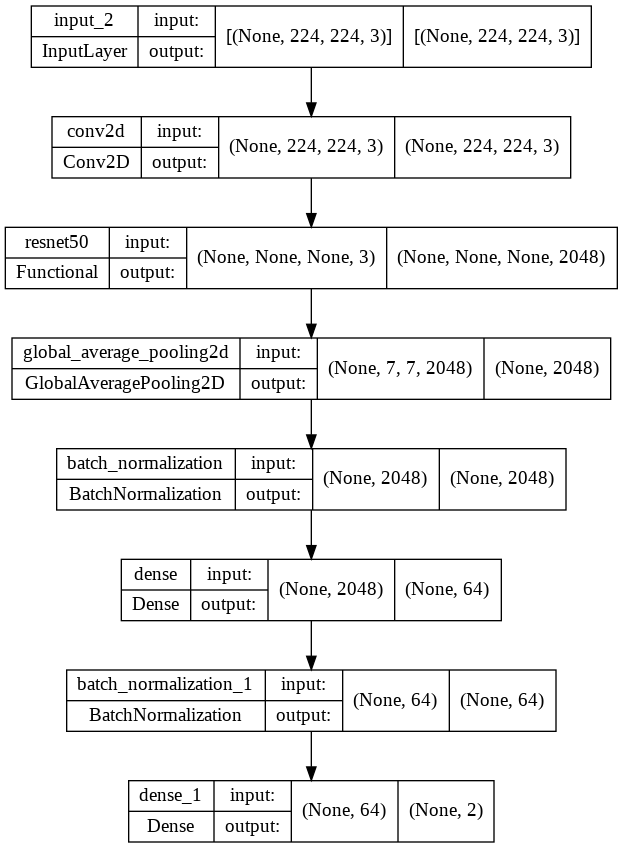

In [9]:
channels = 3

model = build_ResNet50(IMAGE_SIZE, channels)
annealer = ReduceLROnPlateau(monitor = 'val_accuracy',  # Reduce learning rate when Validation accuracy remains constant
                             factor = 0.70,  # Rate by which the learning rate will decrease
                             patience = 5,   # number of epochs without improvement, after which the learning rate will decrease
                             verbose = 1,    # Display messages
                             min_lr = 1e-4   # lower limit on the learning rate.
                            )
checkpoint = ModelCheckpoint('model.h5', verbose = 1, save_best_only = True)  # Save neural network weights

# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range = 360, # Degree range for random rotations
                        width_shift_range = 0.2,   # Range for random horizontal shifts
                        height_shift_range = 0.2,  # Range for random vertical shifts
                        zoom_range = 0.2,          # Range for random zoom
                        horizontal_flip = True,    # Randomly flip inputs horizontally
                        vertical_flip = True)      # Randomly flip inputs vertically

datagen.fit(X_train)

plot_model(model, to_file = 'convnet.png', show_shapes = True, show_layer_names = True)

# 6. **Training the Model**

In [10]:
BATCH_SIZE = 8
EPOCHS = 50

# Fit of the model that includes the augmented images in terms of their characteristics
hist = model.fit(datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE),
               steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
               epochs = EPOCHS,
               verbose = 1,
               callbacks = [annealer, checkpoint],
               validation_data = (X_val, Y_val))

Epoch 1/50
248/248 [==============================] - ETA: 0s - loss: 0.6146 - accuracy: 0.7359
Epoch 1: val_loss improved from inf to 4.68321, saving model to model.h5
248/248 [==============================] - 59s 150ms/step - loss: 0.6146 - accuracy: 0.7359 - val_loss: 4.6832 - val_accuracy: 0.4869 - lr: 0.0030
Epoch 2/50
248/248 [==============================] - ETA: 0s - loss: 0.4294 - accuracy: 0.8059
Epoch 2: val_loss improved from 4.68321 to 2.25375, saving model to model.h5
248/248 [==============================] - 35s 141ms/step - loss: 0.4294 - accuracy: 0.8059 - val_loss: 2.2537 - val_accuracy: 0.4869 - lr: 0.0030
Epoch 3/50
248/248 [==============================] - ETA: 0s - loss: 0.3833 - accuracy: 0.8372
Epoch 3: val_loss improved from 2.25375 to 1.27102, saving model to model.h5
248/248 [==============================] - 34s 136ms/step - loss: 0.3833 - accuracy: 0.8372 - val_loss: 1.2710 - val_accuracy: 0.5151 - lr: 0.0030
Epoch 4/50
248/248 [========================

##### Observations :      
1- My **final Accuracy** is **0.9798**.
2. **final Loss** is **0.0610**.
3. **Val_loss** is **0.0809**.
4. **Val_accuracy** is **0.9790**.

## **Checking the Accuracy**

True Positive: 246
False Negative: 9
True Negative: 241
False Positive: 1
True Positive Rate: 0.9647058823529412
True Negative Rate: 0.9958677685950413

16/16 [==============================] - 2s 103ms/step - loss: 0.0809 - accuracy: 0.9799

Final Loss: 0.08092107623815536, Final Accuracy: 0.9798792600631714


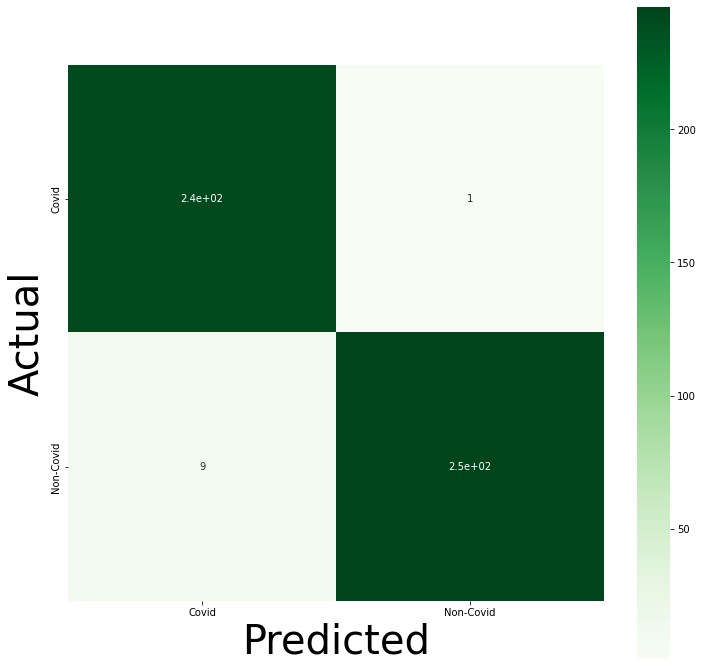

In [11]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_val, axis = 1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize = (12, 12))
ax = sns.heatmap(cm, cmap = plt.cm.Greens, annot = True, square = True, xticklabels = disease_types, yticklabels = disease_types)
ax.set_ylabel('Actual', fontsize = 40)
ax.set_xlabel('Predicted', fontsize = 40)


TP = cm[1][1]
print(f"True Positive: {TP}")


FN = cm[1][0]
print(f"False Negative: {FN}")

TN = cm[0][0]
print(f"True Negative: {TN}")

FP = cm[0][1]
print(f"False Positive: {FP}")

# Sensitivity, recall, or true positive rate
print(f"True Positive Rate: {TP / (TP + FN)}")

# Specificity or true negative rate
print(f"True Negative Rate: {TN / (TN + FP)}\n")

final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print(f"\nFinal Loss: {final_loss}, Final Accuracy: {final_accuracy}")

##### Observations :      
1- **True Positive: 246**

2- False Negative: 9

3- **True Negative: 241**

4- False Positive: 1

5- **True Positive Rate: 0.9647058823529412**

6- **True Negative Rate: 0.9958677685950413**

# 7. Comparing the Model Acccuracy

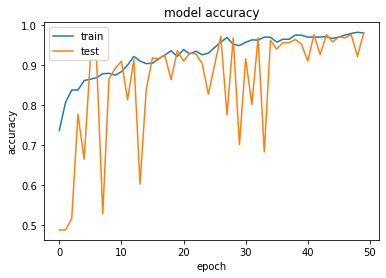

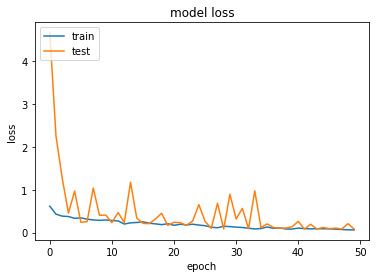

In [12]:
# Accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# 8. **Predicting the Images**

## Test 1

[9.99899626e-01 1.00384554e-04]


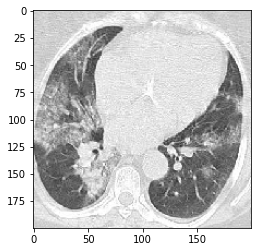

Prediction: Covid-19


In [15]:
from keras.preprocessing import image

img = image.load_img('/content/drive/MyDrive/Colab Notebooks/Capstone Project/Dataset/Covid/Covid (1015).png', grayscale = False, target_size = (IMAGE_SIZE, IMAGE_SIZE))
show_img = image.load_img('/content/drive/MyDrive/Colab Notebooks/Capstone Project/Dataset/Covid/Covid (1011).png', grayscale = False, target_size = (200, 200))
disease_class = ['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a = custom[0]
ind = np.argmax(a)
        
print('Prediction:',disease_class[ind])

## Test 2

[0.0328724 0.9671277]


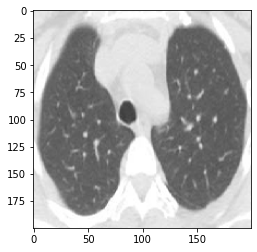

Prediction: Non Covid-19


In [14]:
from keras.preprocessing import image

img = image.load_img('/content/drive/MyDrive/Colab Notebooks/Capstone Project/Dataset/Non-Covid/Non-Covid (1017).png', grayscale = False, target_size = (IMAGE_SIZE, IMAGE_SIZE))
show_img = image.load_img('/content/drive/MyDrive/Colab Notebooks/Capstone Project/Dataset/Non-Covid/Non-Covid (1017).png', grayscale = False, target_size = (200, 200))
disease_class = ['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a = custom[0]
ind = np.argmax(a)
        
print('Prediction:',disease_class[ind])

## Test 3

[4.2860906e-04 9.9957138e-01]


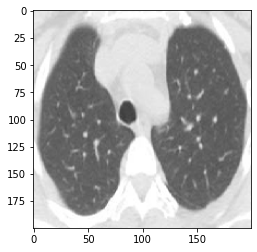

Prediction: Non Covid-19


In [16]:
from keras.preprocessing import image

img = image.load_img('/content/drive/MyDrive/Colab Notebooks/Capstone Project/Dataset/Non-Covid/Non-Covid (1027).png', grayscale = False, target_size = (IMAGE_SIZE, IMAGE_SIZE))
show_img = image.load_img('/content/drive/MyDrive/Colab Notebooks/Capstone Project/Dataset/Non-Covid/Non-Covid (1017).png', grayscale = False, target_size = (200, 200))
disease_class = ['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a = custom[0]
ind = np.argmax(a)
        
print('Prediction:',disease_class[ind])

# **As we can see all the points are predected correctly**.

# The **Capstone Project** has been **completed Succesfully**.